# Model Evaluation

In this notebook we will test the resulting trained model on the test set, and we will delve into the model to understand better where it does good, where it does less good, and why this is the case.

In [14]:
from arguments import test_set_path, model_file
import pandas as pd
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tempfile import NamedTemporaryFile
import shap

Here we use the model trained to predict the score of the wine for a part of the dataset that has not been seen during the training phase.
This means that this replicates exactly a real life scenario of the model in action.

In [20]:
test_set = pd.read_csv(test_set_path)
test_y = test_set[['points']]
test_x = test_set.drop(columns=['points'])

model = XGBRegressor()
model.load_model(model_file)

print('Making inferences...')
started = time()
pred_test_y = model.predict(test_x)

print(f"On test set, mean squared error is "
      f"{mean_squared_error(test_y, pred_test_y)} "
      f"({len(test_y)} predictions in {time()-started} seconds)")

Making inferences...
On test set, mean squared error is 4.057127944223426 (1989 predictions in 0.0225522518157959 seconds)


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


The resulting error is comparable to what we obtained during training phase, meaning that we should not have surprises when using it in a production environment.

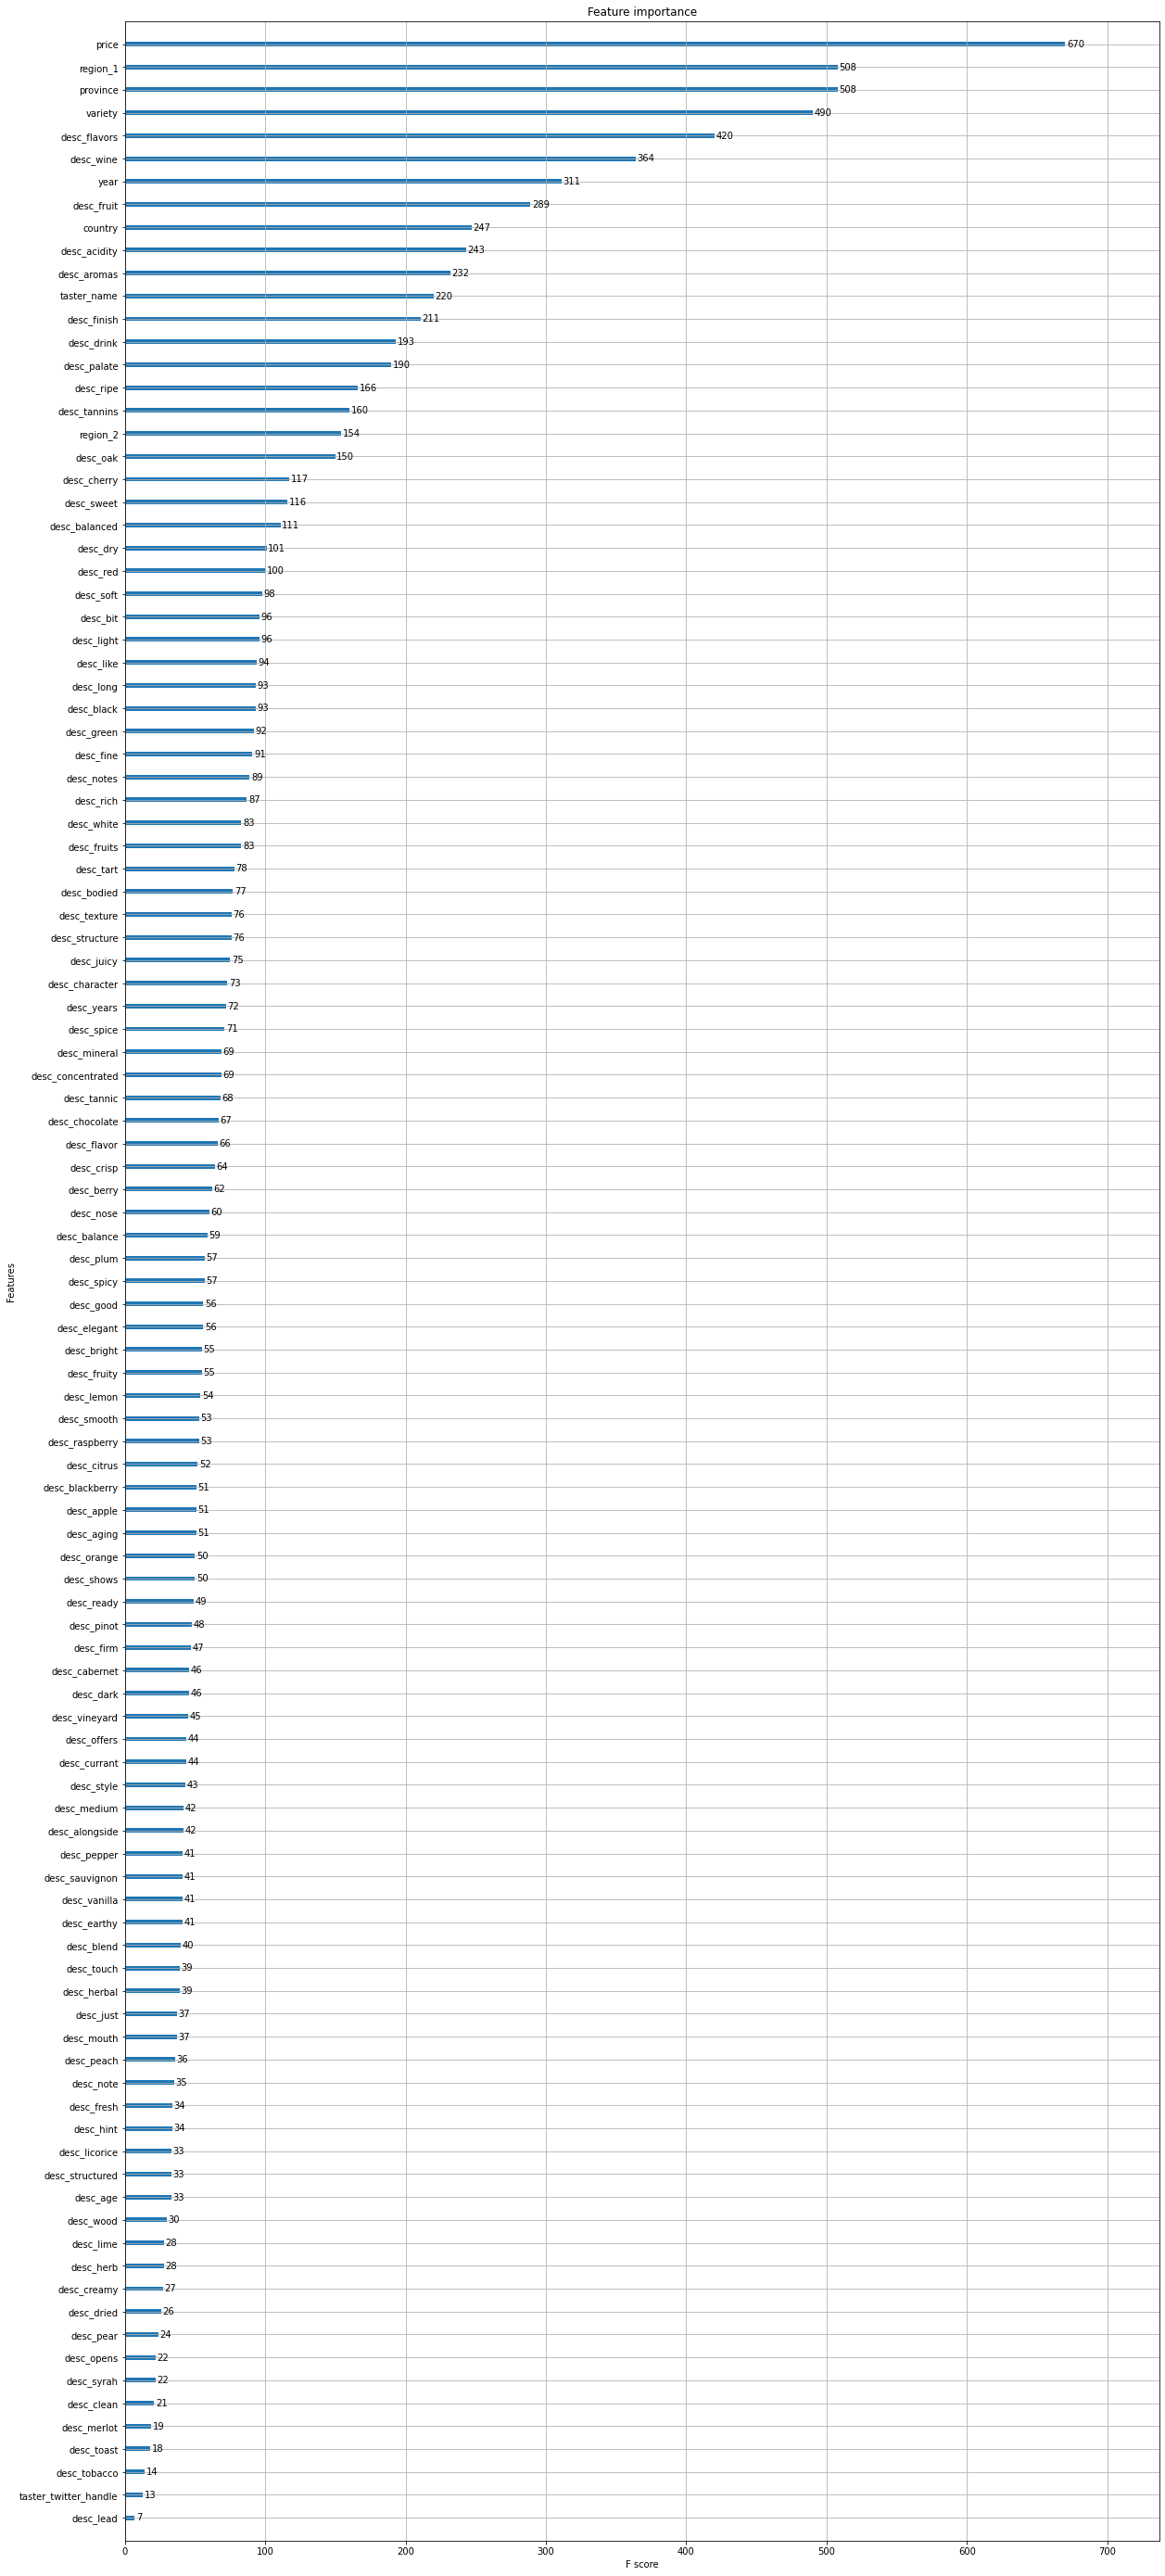

In [13]:
with NamedTemporaryFile(suffix='.tsv', mode='w+') as open_tsv:
    for i, column_name in enumerate(test_x.columns):
        open_tsv.write(f"{i}\t{column_name}\tq\n")
    open_tsv.flush()
    open_tsv.seek(0)

    fig, ax = plt.subplots(figsize=(20, 50))
    plot_importance(model,ax=ax, fmap=open_tsv.name)

    plt.show()

When checking for the most important variables when assigning points to a wine, we see that the results are similar to what we observer in experimentation phase.

Apart from the price, which is the feature that helps the most at determining a wine's points, we see that variety and specific data about where the wine comes from have the same impact, reflecting the known fact that certain varieties produce better wine in specific regions. 

We can also see what are the most relevant words that are found in reviews to rate a wine. `flavors`, `fruit`, `aroma`, `acidity`, `finish` are all words that, along with a numerical representation on how important they are to a description in the collection of descriptions, have the most impact in rating a wine. 
It is also interesting to note that these descriptional words are more important than informational words, such as `red` and `white` which identify the type of wine, but do not give as much information on the taste.

In [26]:
# Calculate difference between score assigned by the model, and real score.
prediction_discrepancies = [abs(original-predicted) for original, predicted in zip(test_y.values.ravel(), pred_test_y)]
# Get a list of indices of sorted discrepancies, from the clostest prediction, to the most wrong one.
indices_sorted_discrepancies = sorted(range(len(prediction_discrepancies)), key=lambda k: prediction_discrepancies[k])
best_pred_i = indices_sorted_discrepancies[0]
worst_pred_i = indices_sorted_discrepancies[len(prediction_discrepancies) -1]
print(f'The best prediction gets the score wrong by {prediction_discrepancies[best_pred_i]} points')
print(f'The worst prediction gets the score wrong by {prediction_discrepancies[worst_pred_i]} points')

The best prediction gets the score wrong by 0.00110626220703125 points
The worst prediction gets the score wrong by 7.319129943847656 points


<AxesSubplot:ylabel='Count'>

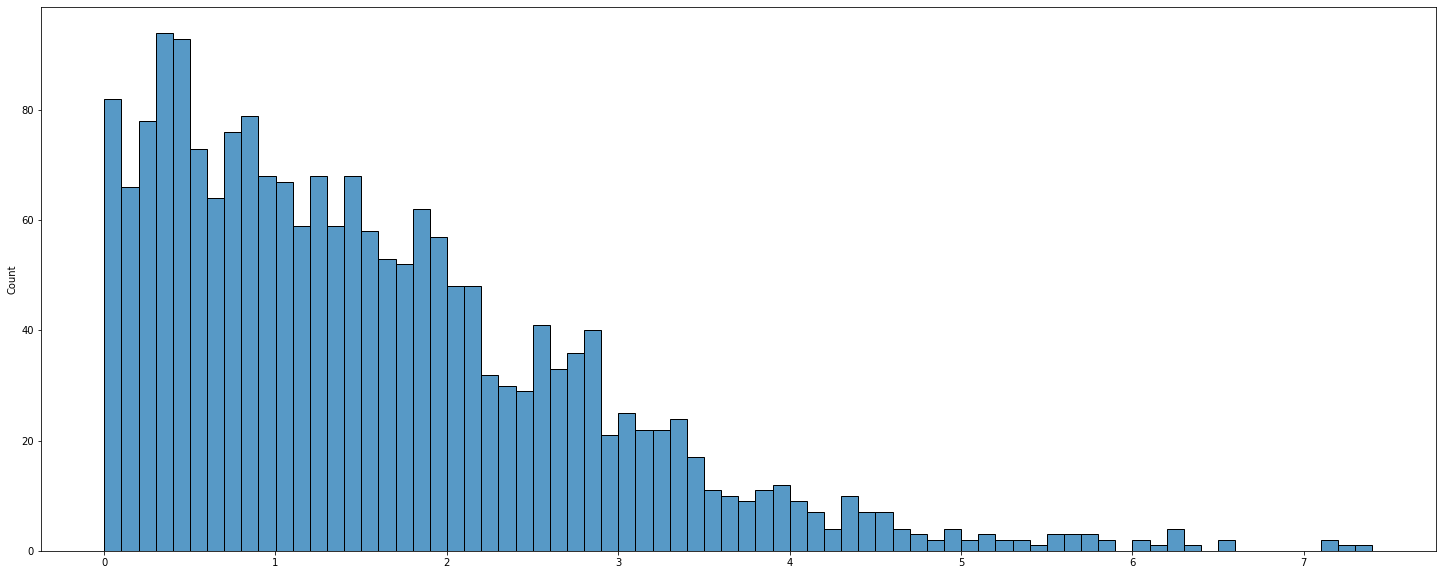

In [45]:
plt.figure(figsize=(25, 10))
sns.histplot(data=prediction_discrepancies, binwidth = 0.1)

We can see the distribution of errors on the test set, which is a distribution more skewed towards the zero, the largest errors being by about 7 points.

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(test_x)

In order to see what happens when a good or bad prediction happen, we plot the waterfall shap to see what each variables contribute for the score assigned, for the better or worse.

correct value is 85, the predicted one 84.99889373779297


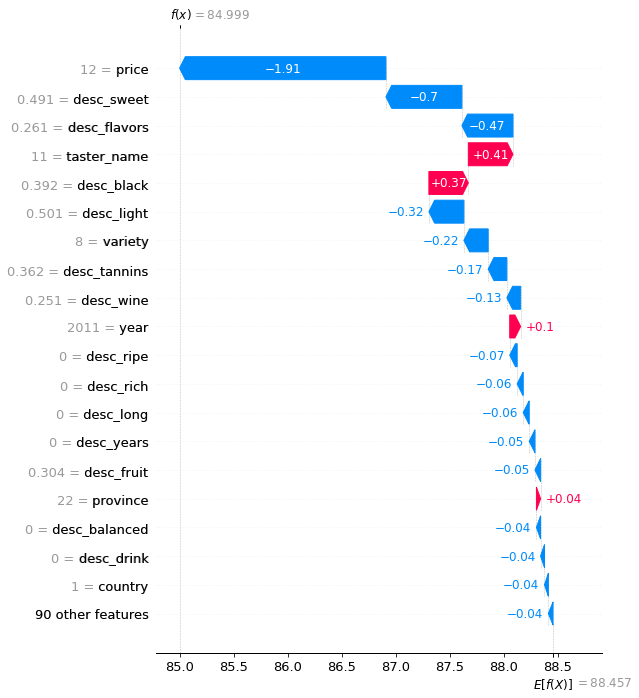

In [38]:
print(f'correct value is {list(test_y.values.ravel())[best_pred_i]}, the predicted one {list(pred_test_y)[best_pred_i]}')
# visualize the best prediction's explanation
shap.plots.waterfall(shap_values[best_pred_i], max_display=20)

In the best case, there was a very strong correlation with the price and the points assigned, and so the price is most important feature. We see how the combination of other features influence the prediction: the fact that words like light and sweet are very relevant in its description also tends to give it a lower score from the average.

correct value is 82, the predicted one 89.31912994384766


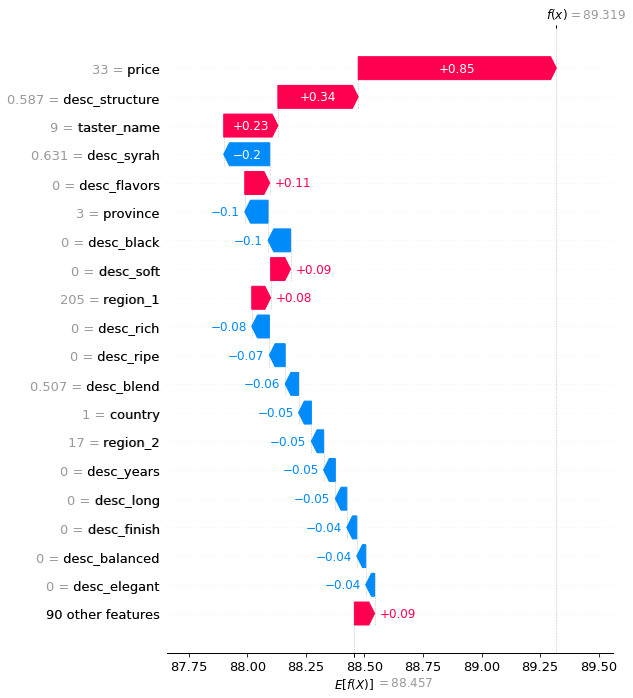

In [39]:
print(f'correct value is {list(test_y.values.ravel())[worst_pred_i]}, the predicted one {list(pred_test_y)[worst_pred_i]}')
# visualize the worst prediction's explanation
shap.plots.waterfall(shap_values[worst_pred_i], max_display=20)

In the worst case, we can see that the error is due to the fact that the wine is probabily overpriced. The lack of important words for more refined wines seems to suggest that the model tried to counterbalance the mistake (`ripe`, `elegant`, `balanced`, `rich`), but the combination of a high price and a high value for a word like `structure` (that suggests an important wine), was enough to throw the model off.

## Does it make sense to implement the model?

We showed how it was possible to develop a model that improves a lot over the baseline (53% improvement), that returns good results (the worst error in the test set was by 7 points). This definitely will help assigning in an automated manner scores to wines, saving loads of precious time, but at the same time being confident that the errors are limited.

Since the price is such an important variable, errors can be spotted when the price of a wine seems too high or too low for what it is. In other cases, the benefits of the system outweight the imprecisions.